# Evolution of Einstein's equations

# Initial data constants definition

# Initial data , setting length of the domain and discretization


In [154]:
res

1

In [155]:
m=1;
res=m;
N=2.0^m*500.0;#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 0.8


In [156]:
print(N)

1000.0

In [157]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.001
dt =0.0004
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2) = 0.625


In [158]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"

In [159]:
println(dx)
println(dt)

0.001
0.0004


In [160]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [161]:
ori=0.0;
X1 = nothing
X1=range(ori, stop=Xf, step=dx);

println(size(X1))
println(X1)

(1001,)
0.0:0.001:1.0


In [162]:
print(dx)
X = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(X);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)
println(size(T))
println(size(X))

println(X[L-3])
println(L)

0.001step size is  0.001
the time step is 0.0004
(2000,)
(1007,)
1.0
1007


In [163]:
radius=zeros(L)
print(L)
print(size(X1))
print(X1[1001])
for i in 1:L
    radius[i]=X[i]/(1-X[i])
end


1007(1001,)1.0

In [164]:
include("./ScalarField.jl");

In [165]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [166]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initphi=zeros(L);
initphibar=zeros(L);

#PHI,X

r0=0.7
sigma=0.3
A=0.1449
initphibar[4:L-3] = init_gaussian_der(X1,r0,sigma,A)



#PHI FROM PSI,X
spl = scipyinterpolate.splrep(X[4:L-3], initphibar[4:L-3],k=5)
phi0=0
SFconstraint_phi_new(phi0,x) = scipyinterpolate.splev(x, spl)
initphi[4:L-3] = rungekutta4(SFconstraint_phi_new,phi0,X1)#,state_array[4:L-3,:])


#PHI
"initphi = init_gaussian(R,r0,sigma,A)"




"initphi = init_gaussian(R,r0,sigma,A)"

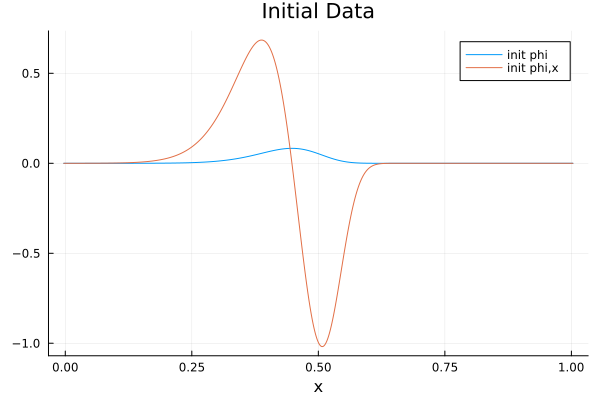

In [167]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X, [initphi initphibar], xaxis="x",title="Initial Data", labels=["init phi" "init phi,x"])

In [168]:
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initpsibar=zeros(L);
state_array=[initm initbeta initpsi initpsibar];


#PSI
initpsi = initphi .* X ./ (1 .- X)
initpsi[L-3]=0
state_array[:,3]=initpsi;
state_array=ghost(state_array);


#PSI,X
initpsibar = initphibar .* X ./ (1 .- X) +  initphi ./ (1 .- X) .^2
initpsibar[L-3]=0
state_array[:,4]=initpsibar;
state_array=ghost(state_array);

spl_m = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)

beta_func(x) = m_func(x)

spl_psi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,3],k=4)
psi_func(x) = scipyinterpolate.splev(x, spl_psi)

spl_derpsi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=4)
derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

spl_funcs = [m_func beta_func psi_func derpsi_func]

#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,X1,0,spl_funcs)
state_array[:,2]=initbeta;
state_array=ghost(state_array);

#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,X1,0,spl_funcs)
state_array[:,1]=initm;
state_array=ghost(state_array);

spl_m = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)
spl_funcs[1] = m_func

spl_beta = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=4)
beta_func(x) = scipyinterpolate.splev(x, spl_beta)
spl_funcs[2] = beta_func

beta_func (generic function with 1 method)

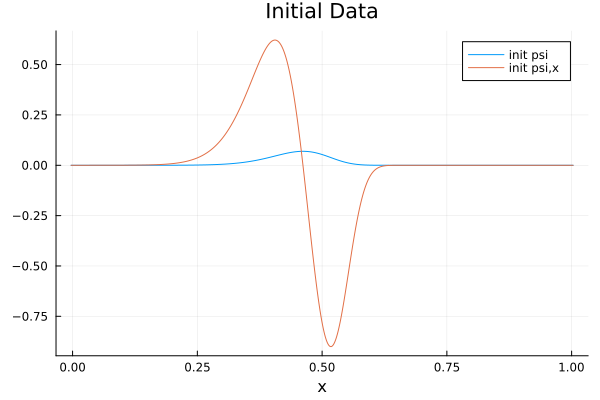

In [169]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X, [initpsi initpsibar], xaxis="x",title="Initial Data", labels=["init psi" "init psi,x"])

In [170]:
#monitor_ratio = 1-v/rexp(-2beta)
monitor_ratio = zeros(L)
for i in 1:L
    monitor_ratio = 2*state_array[:,1]/X[i]*(1-X[i])
    if monitor_ratio[i]>0.6
        print(monitor_ratio[i])
    end
end

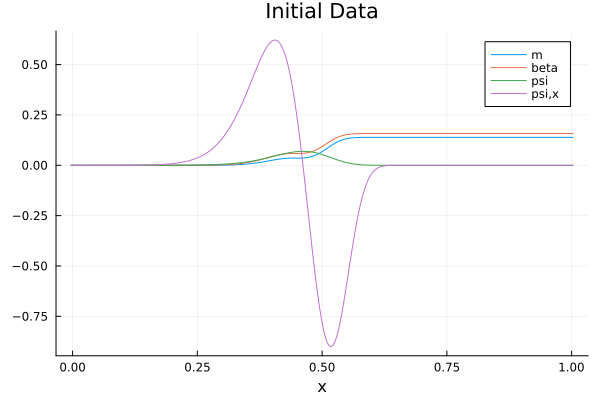

In [171]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X, state_array, xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [172]:
using CSV, Tables
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

 ## Time evolution

In [174]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)

    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0,spl_funcs) #evolve psi,x
    state_array=ghost(state_array)
    
    spl_derpsi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=4)
    derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)
    spl_funcs[4] = derpsi_func
    
    #calculate psi form psi,x
    psi0=0
    SFconstraint_psi(psi0,x) = derpsi_func(x)
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,X1)
    state_array=ghost(state_array);
    
    spl_psi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,3],k=4)
    psi_func(x) = scipyinterpolate.splev(x, spl_psi)
    spl_funcs[3] = psi_func
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,X1,T,spl_funcs)
    state_array=ghost(state_array)
    
    spl_m = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,1],k=4)
    m_func(x) = scipyinterpolate.splev(x, spl_m)
    spl_funcs[1] = m_func
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,T,spl_funcs)
    state_array=ghost(state_array)
    
    spl_beta = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=4)
    beta_func(x) = scipyinterpolate.splev(x, spl_beta)
    spl_funcs[2] = beta_func
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

Progress:   0%|                                         |  ETA: 0:41:00

LoadError: InterruptException:

In [175]:
print(dir)

/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1

## Movie of the evolution

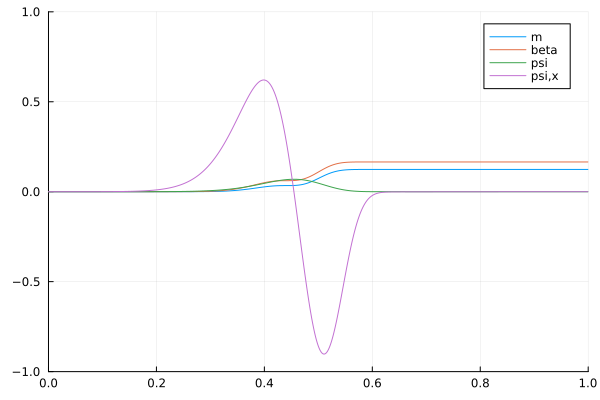

┌ Info: Saved animation to 
│   fn = /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif
└ @ Plots /home/rita13santos/.julia/packages/Plots/fw4rv/src/animation.jl:156


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
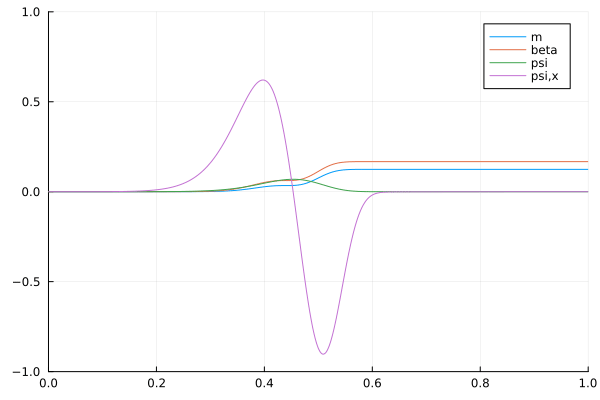

In [177]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1:1:33#length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
    d=round(T[n],digits=1)
    plot!(X1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-1, 1], xlim=[0, 1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1)

In [128]:
X[5]

0.001

2001
[0.0, 7.897982266498912e-14, 6.377307553777871e-13, 2.172419275496502e-12, 5.197489866847073e-12, 1.0246104186668724e-11, 1.787058891284146e-11, 2.864289242420148e-11, 4.3155050469193906e-11, 6.201966098064276e-11, 8.587036819695707e-11, 1.1536235625268521e-10, 1.5117285240395396e-10, 1.940016400569949e-10, 2.4457158177066786e-10, 3.0362915240663516e-10, 3.7194498260363154e-10, 4.503144127550981e-10, 5.395580576723268e-10, 6.405223821181683e-10, 7.540802873993189e-10, 8.81131709208202e-10, 1.0226042269085024e-9, 1.1794536844615047e-9, 1.352664823193527e-9, 1.543251926607914e-9, 1.7522594774482957e-9, 1.980762827223085e-9, 2.22986887840452e-9, 2.5007167795189235e-9, 2.7944786333482955e-9, 3.1123602184667938e-9, 3.4556017243392217e-9, 3.825478500212197e-9, 4.223301818032307e-9, 4.650419649629232e-9, 5.108217458405589e-9, 5.598119005778989e-9, 6.121587172625658e-9, 6.680124795978928e-9, 7.27527552123978e-9, 7.908624670160683e-9, 8.581800124868051e-9, 9.296473228192753e-9, 1.005435970

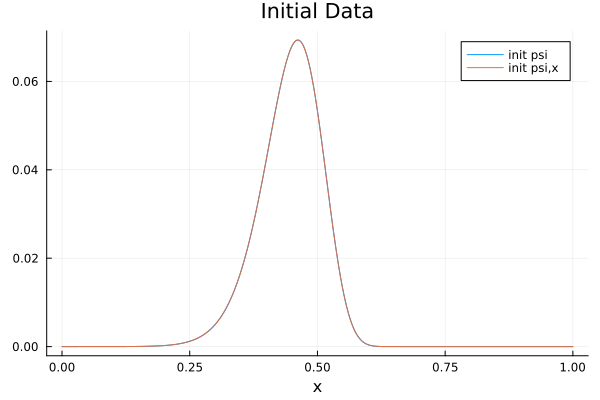

In [221]:
aa = SFconstraint_4(beta0,X1,state_array[4:L-3,:])
println(length(aa))

println(aa) # == state_array[4:L-3,3]

plot(X1, [aa, state_array[4:L-3,3]], xaxis="x",title="Initial Data", labels=["init psi" "init psi,x"])

In [222]:
print(aa-state_array[4:L-3,3])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [51]:
spl = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=5)
f(x) = scipyinterpolate.splev(x, spl)

f(0.5)
#z = 2.0 .* pi .* (1.0 .- x1) .* f[x1]

0-dimensional Array{Float64, 0}:
0.0005235987755982988

In [52]:
state_array[1004,2]

0.0005235987755982988

In [53]:
print(X[1004])

0.5

In [117]:
aux=state_array[4:L-3,:]
aux[:,2]=zeros(L-6)
bb = SFconstraint_4(beta0,X1,state_array[4:L-3,:])
println(length(bb))
println(bb)

2001
[-2.276993760953177e-25, 2.9851868644513903e-9, 1.2083245494367064e-8, 2.7511617194290325e-8, 4.949274323655073e-8, 7.825415905898219e-8, 1.1402859003703194e-7, 1.5705404885447227e-7, 2.0757393449709592e-7, 2.658371328941882e-7, 3.320981192328848e-7, 4.066170619708989e-7, 4.896599285734445e-7, 5.814985930005408e-7, 6.824109449712777e-7, 7.926810010319447e-7, 9.125990174553613e-7, 1.0424616049990654e-6, 1.1825718455504528e-6, 1.3332394106873177e-6, 1.49478068218267e-6, 1.6675188744830504e-6, 1.8517841591900452e-6, 2.0479137915750617e-6, 2.256252239157825e-6, 2.4771513123795438e-6, 2.7109702974020566e-6, 2.95807609106471e-6, 3.2188433380312113e-6, 3.4936545701590574e-6, 3.782900348124612e-6, 4.0869794053374805e-6, 4.406298794178007e-6, 4.741274034592517e-6, 5.092329265081132e-6, 5.4598973961136425e-6, 5.84442026600924e-6, 6.24634879931656e-6, 6.666143167730822e-6, 7.1042729535855364e-6, 7.561217315956552e-6, 8.037465159416833e-6, 8.533515305480938e-6, 9.049876666778504e-6, 9.5870684

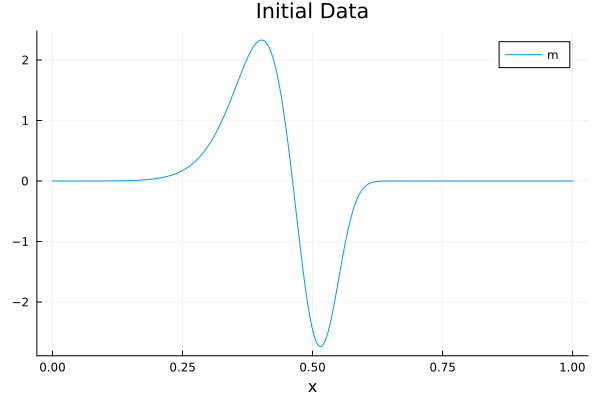

In [119]:
using Plots #showing initial data and the initial status of the horizon finder
plot(X1, bb, xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

In [86]:
println(length(state_array[4:L-3,2]))
println(state_array[4:L-3,2])

2001
[0.0, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 0.0005235987755982988, 